# Prepare Workspace

## Load required modules

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import datetime
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats
from sklearn.cluster import KMeans
from scipy.stats import spearmanr, kendalltau
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold, train_test_split, cross_validate

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [2]:
#functions definition

def gini_coefficient(values):
    values = np.array(values)
    n = len(values)
    sorted_values = np.sort(values)
    index = np.arange(1, n + 1)
    return (np.sum((2 * index - n - 1) * sorted_values)) / (n * np.sum(sorted_values))

def theil_index(values):
    values = np.array(values)
    n = len(values)
    mean = np.mean(values)
    return np.sum((values / mean) * np.log(values / mean)) / n

def lorenz_curve(values):
    values = np.sort(np.array(values))
    n = len(values)
    cum_frequencies = np.cumsum(values) / np.sum(values)
    return np.concatenate(([0], cum_frequencies))

def theil_contributions(values):
    values = np.array(values)
    mean = np.mean(values)
    return (values / mean) * np.log(values / mean)

In [3]:
targets       = ['MAX_Completeness_pct', 'Weeks2MAX', 'IDX_W2M']
spatial       = ['Population Density (Per Sq. Mile)', 'Average Commute to Work (In Min)', 'AREA_SQMI', 'Density_Medical_Facilities_Population', 'Density_Medical_Facilities_Area', 'Density_Transportation_Stops_Pop', 'Density_Transportation_Stops_Area', 'Stops_per_Facility']
socioeconomic = ["% Total Population: Male","% Total Population: Female","% Total Population: White Alone","% Total Population: Black or African American Alone","% Total Population: American Indian and Alaska Native Alone","% Total Population: Asian Alone","% Total Population: Two or More Races","% Population 16 Years and Over: in Labor Force","% Population 16 Years and Over: in Labor Force: in Armed Forces","% Population 16 Years and Over: in Labor Force: Civilian","% Population 16 Years and Over: in Labor Force: Civilian: Employed","% Population 16 Years and Over: in Labor Force: Civilian: Unemployed","% Population 16 Years and Over: Not in Labor Force","% Households: Less than $25,000","% Households: $25,000 to $49,999","% Households: $50,000 to $74,999","% Households: $75,000 to $99,999","% Households: $100,000 or More","Median Household Income (In 2021 Inflation Adjusted Dollars)","Gini Index","% Workers 16 Years and Over: Car, Truck, or Van","% Workers 16 Years and Over: Drove Alone","% Workers 16 Years and Over: Carpooled","% Workers 16 Years and Over: Public Transportation (Includes Taxicab)","% Workers 16 Years and Over: Motorcycle","% Workers 16 Years and Over: Bicycle","% Workers 16 Years and Over: Walked","% Workers 16 Years and Over: Other Means","% Workers 16 Years and Over: Worked At Home","% Total: No Health Insurance Coverage","% Total: with Health Insurance Coverage","% Total: with Health Insurance Coverage: Public Health Coverage","% Total: with Health Insurance Coverage: Private Health Insurance","EP_POV150","EP_UNEMP","EP_HBURD","EP_NOHSDP","EP_UNINSUR","EP_AGE65","EP_AGE17","EP_SNGPNT","EP_LIMENG","EP_MINRTY","EP_MUNIT","EP_MOBILE","EP_CROWD","EP_NOVEH","EP_GROUPQ","F_POV150","F_UNEMP","F_HBURD","F_NOHSDP","F_UNINSUR","F_THEME1","F_AGE65","F_AGE17","F_DISABL","F_SNGPNT","F_LIMENG","F_THEME2","F_MINRTY","F_THEME3","F_MUNIT","F_MOBILE","F_CROWD","F_NOVEH","F_GROUPQ","F_THEME4","F_TOTAL",'%DAYPOP',"EP_NOINT","EP_AFAM","EP_HISP","EP_ASIAN","EP_AIAN","EP_TWOMORE","EP_OTHERRACE","%Total Child Population",'%Total University','%Total High school','%Total Less than High School','%Total Adult Population','%Total Elderly Population',"%Population with Disability","%LIMENG","%NOINT"]
others        = ["Total Population", 'Area (Land)',"Total Population:","Total Population:.1","EP_NHPI","Qualifying Name","File identification","State Postal Abbreviation","Summary Level","Geographic Component","Logical Record Number","US","Census Region","Census Division","State (Census Code)","State (FIPS Code)","County of current residence","County Subdivision (FIPS)","Place (FIPS Code)","Census Tract","Block Group","Consolidated City","American Indian Area/AlaskaNative Area/ Hawaiian Home Land(Census)","% Total Population: Under 5 Years","% Total Population: 5 to 9 Years","% Total Population: 10 to 14 Years","% Total Population: 15 to 17 Years","% Population 25 Years and Over: Less than High School","% Population 25 Years and Over: High School Graduate or More (Includes Equivalency)","% Population 25 Years and Over: Some College or More","% Population 25 Years and Over: Bachelor's Degree or More","% Population 25 Years and Over: Master's Degree or More","% Population 25 Years and Over: Professional School Degree or More","% Population 25 Years and Over: Doctorate Degree""% Total Population: 18 to 24 Years","% Total Population: 25 to 34 Years","% Total Population: 35 to 44 Years","% Total Population: 45 to 54 Years","% Total Population: 55 to 64 Years","% Total Population: 65 to 74 Years","% Total Population: 75 to 84 Years","% Total Population: 85 Years and Over""American Indian Area/AlaskaNative Area/ Hawaiian Home Land(FIPS)","American Indian Trust Land/Hawaiian Home Land Indicator","American Indian TribalSubdivision (Census)","American Indian TribalSubdivision (FIPS)","% Total Population: Some Other Race Alone","Alaska Native RegionalCorporation (FIPS)","% Total Population: Native Hawaiian and Other Pacific Islander Alone","Metropolitan and MicropolitanStatistical Area","Combined Statistical Area","Metropolitan Statistical Area-Metropolitan Division","Metropolitan Area Central City","Metropolitan/MicropolitanIndicator Flag","New England City and Town Area","New England City and TownCombined Statistical Area","New England City and Town AreaDivision","Urban Area","Urban Area Central Place","Current Congressional District ***","State Legislative District Upper","State Legislative District Lower","Voting District","ZIP Code Tabulation Area (3-digit)","5-digit ZIP Code Tabulation Area","Subminor Civil Division (FIPS)","State-School District (Elementary)","State-School District (Secondary)","State-School District (Unified)","Urban/Rural","Principal City Indicator","Traffic Analysis Zone","Urban Growth Area","Public Use Microdata Area â€“ 5%File","Public Use Microdata Area - 1% File","Geographic Identifier","Area Name","Tribal Tract","Tribal Block Group","Place (State FIPS + Place FIPS)","Total Population: Male","Total Population: Female","Total Population: Under 5 Years","Total Population: 5 to 9 Years","Total Population: 10 to 14 Years","Total Population: 15 to 17 Years","Total Population: 18 to 24 Years","Total Population: 25 to 34 Years","Total Population: 35 to 44 Years","Total Population: 45 to 54 Years","Total Population: 55 to 64 Years","Total Population: 65 to 74 Years","Total Population: 75 to 84 Years","Total Population: 85 Years and Over","Total Population:.2","Total Population: White Alone","Total Population: Black or African American Alone","Total Population: American Indian and Alaska Native Alone","Total Population: Asian Alone","EP_DISABL","Total Population: Native Hawaiian and Other Pacific Islander Alone","Total Population: Some Other Race Alone","Total Population: Two or More Races","SPL_THEME1","RPL_THEME1","E_TOTPOP","Population 25 Years and Over:","SPL_THEME2","RPL_THEME2","SPL_THEME3","RPL_THEME3","SPL_THEME4","RPL_THEME4","SPL_THEMES","E_DAYPOP","RPL_THEMES","Population 25 Years and Over: Less than High School","Population 25 Years and Over: High School Graduate or More (Includes Equivalency)","Population 25 Years and Over: Some College or More","Population 25 Years and Over: Bachelor's Degree or More","Population 25 Years and Over: Master's Degree or More","Population 25 Years and Over: Professional School Degree or More","Population 25 Years and Over: Doctorate Degree","Population 16 Years and Over:","Population 16 Years and Over: in Labor Force","Population 16 Years and Over: in Labor Force: in Armed Forces","Population 16 Years and Over: in Labor Force: Civilian","Population 16 Years and Over: in Labor Force: Civilian: Employed","Population 16 Years and Over: in Labor Force: Civilian: Unemployed","Population 16 Years and Over: Not in Labor Force","Households:","Households: Less than $25,000","Households: $25,000 to $49,999","Households: $50,000 to $74,999","Households: $75,000 to $99,999","Households: $100,000 or More","Workers 16 Years and Over:","Workers 16 Years and Over: Car, Truck, or Van","Workers 16 Years and Over: Drove Alone","Workers 16 Years and Over: Carpooled","Workers 16 Years and Over: Public Transportation (Includes Taxicab)","Workers 16 Years and Over: Motorcycle","Workers 16 Years and Over: Bicycle","Workers 16 Years and Over: Walked","Workers 16 Years and Over: Other Means","Workers 16 Years and Over: Worked At Home","Total:","Total: No Health Insurance Coverage","Total: with Health Insurance Coverage","Total: with Health Insurance Coverage: Public Health Coverage","Total: with Health Insurance Coverage: Private Health Insurance","W","ST","STATE","ST_ABBR","STCNTY","COUNTY","LOCATION","M_TOTPOP","E_HU","M_HU","E_HH","M_HH","E_POV150","M_POV150","E_UNEMP","M_UNEMP","E_HBURD","M_HBURD","E_NOHSDP","M_NOHSDP","E_UNINSUR","M_UNINSUR","E_AGE65","M_AGE65","E_AGE17","M_AGE17","E_DISABL","M_DISABL","E_SNGPNT","M_SNGPNT","E_LIMENG","M_LIMENG","E_MINRTY","M_MINRTY","E_MUNIT","M_MUNIT","E_MOBILE","M_MOBILE","E_CROWD","M_CROWD","E_NOVEH","M_NOVEH","E_GROUPQ","M_GROUPQ","MP_POV150","MP_UNEMP","MP_HBURD","MP_NOHSDP","MP_UNINSUR","MP_AGE65","MP_AGE17","MP_DISABL","MP_SNGPNT","MP_LIMENG","MP_MINRTY","MP_MUNIT","MP_MOBILE","MP_CROWD","MP_NOVEH","MP_GROUPQ","E_NOINT","M_NOINT","E_AFAM","M_AFAM","E_HISP","M_HISP","E_ASIAN","M_ASIAN","E_AIAN","M_AIAN","E_NHPI","M_NHPI","E_TWOMORE","M_TWOMORE","E_OTHERRACE","M_OTHERRACE","MP_NOINT","MP_AFAM","MP_HISP","MP_ASIAN","MP_AIAN","MP_NHPI","MP_TWOMORE","MP_OTHERRACE","Count_Medical_Facilities","Count_Transportation_Stops","EPL_POV150","EPL_UNEMP","EPL_HBURD","EPL_NOHSDP","EPL_UNINSUR","EPL_AGE65","EPL_AGE17","EPL_DISABL","EPL_SNGPNT","EPL_LIMENG","EPL_MINRTY","EPL_MUNIT","EPL_MOBILE","EPL_CROWD","EPL_NOVEH","EPL_GROUPQ"]

# Data Preprocessing

## Read the file

In [4]:
df_scaled=pd.read_csv('df_counties.csv')
#files.download('df_scaled.csv')

In [5]:
df_scaled["Stops_per_Facility"].replace([-np.inf],np.nan, inplace=True)
df_scaled["Density_Medical_Facilities_Population"].replace([-np.inf],np.nan, inplace=True)
df_scaled["Density_Medical_Facilities_Area"].replace([-np.inf],np.nan, inplace=True)
df_scaled["Density_Transportation_Stops_Pop"].replace([np.inf],np.nan, inplace=True)
df_scaled["Density_Transportation_Stops_Area"].replace([np.inf],np.nan, inplace=True)

In [6]:
df_scaled[np.isinf(df_scaled).any(axis=1)]

,FIPS,MAX_Completeness_pct,Weeks2MAX,IDX_W2M,Population Density (Per Sq. Mile),Area (Land),Average Commute to Work (In Min),AREA_SQMI,Density_Medical_Facilities_Population,Density_Medical_Facilities_Area,...,%Total Child Population,%Total University,%Total High school,%Total Less than High School,%Total Adult Population,%Total Elderly Population,%Population with Disability,%LIMENG,%NOINT,%DAYPOP
282,51081,-0.175545,-1.048116,-0.872572,38.83451,295.227067,23,295.22693,0.0,0.0,...,0.154993,0.358521,0.40742,0.228046,0.692979,0.152028,0.115934,0.003069,0.1675,1.027975


In [7]:
df_scaled.replace([np.inf], np.nan, inplace=True)

In [8]:
df_scaled.dropna(inplace=True)

In [9]:
df_scaled["% Total: No Health Insurance Coverage"] = df_scaled["% Total: No Health Insurance Coverage"].astype(float)/100

## Scale

In [10]:
scaler = StandardScaler()
df_scaled1=df_scaled.copy()
df_scaled[spatial+socioeconomic] = scaler.fit_transform(df_scaled[spatial+socioeconomic])

## Linear regression to test the explainability of the model

In [11]:
X= df_scaled[socioeconomic+spatial]
y = df_scaled['IDX_W2M']
x= sm.add_constant(X)
slr = sm.OLS(y,X).fit()
slr_summary=slr.summary()
print(slr.summary())

                                 OLS Regression Results                                
Dep. Variable:                IDX_W2M   R-squared (uncentered):                   0.020
Model:                            OLS   Adj. R-squared (uncentered):             -0.008
Method:                 Least Squares   F-statistic:                             0.7230
Date:                Tue, 18 Apr 2023   Prob (F-statistic):                       0.973
Time:                        23:20:11   Log-Likelihood:                         -4775.8
No. Observations:                3043   AIC:                                      9722.
Df Residuals:                    2958   BIC:                                  1.023e+04
Df Model:                          85                                                  
Covariance Type:            nonrobust                                                  
                                                                            coef    std err          t      P>|t|      [

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.


In [12]:
X.isna().sum().max()

0

In [13]:
np.isinf(X).sum()

% Total Population: Male                                       0
% Total Population: Female                                     0
% Total Population: White Alone                                0
% Total Population: Black or African American Alone            0
% Total Population: American Indian and Alaska Native Alone    0
                                                              ..
Density_Medical_Facilities_Population                          0
Density_Medical_Facilities_Area                                0
Density_Transportation_Stops_Pop                               0
Density_Transportation_Stops_Area                              0
Stops_per_Facility                                             0
Length: 94, dtype: int64

In [14]:
# Define X and y
X = df_scaled[socioeconomic+spatial]
y = df_scaled['IDX_W2M']

# Reduce the features using correlation

In [15]:
# Define X and y
X = df_scaled[socioeconomic+spatial]
y = df_scaled['IDX_W2M']

# Calculate the correlation matrix (absolute values)
corr_matrix = X.corr().abs()

# Get the upper triangle of the correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find the features with correlation greater than the threshold (0.7)
to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]

# Drop the highly correlated features
X_reduced = X.drop(to_drop, axis=1)

# Print the features kept after removing highly correlated features
print("Features kept after removing highly correlated feature:")
print(X_reduced.columns)

Features kept after removing highly correlated feature:
Index(['% Total Population: Male', '% Total Population: White Alone',
       '% Total Population: American Indian and Alaska Native Alone',
       '% Total Population: Asian Alone',
       '% Total Population: Two or More Races',
       '% Population 16 Years and Over: in Labor Force',
       '% Population 16 Years and Over: in Labor Force: in Armed Forces',
       '% Population 16 Years and Over: in Labor Force: Civilian: Unemployed',
       '% Households: $25,000 to $49,999', '% Households: $50,000 to $74,999',
       '% Households: $75,000 to $99,999', 'Gini Index',
       '% Workers 16 Years and Over: Car, Truck, or Van',
       '% Workers 16 Years and Over: Carpooled',
       '% Workers 16 Years and Over: Public Transportation (Includes Taxicab)',
       '% Workers 16 Years and Over: Motorcycle',
       '% Workers 16 Years and Over: Bicycle',
       '% Workers 16 Years and Over: Walked',
       '% Workers 16 Years and Over: O

In [16]:
# Print the features dropped due to high correlation
print("Features dropped due to high correlation:")
print(to_drop)

Features dropped due to high correlation:
['% Total Population: Female', '% Total Population: Black or African American Alone', '% Population 16 Years and Over: in Labor Force: Civilian', '% Population 16 Years and Over: in Labor Force: Civilian: Employed', '% Population 16 Years and Over: Not in Labor Force', '% Households: Less than $25,000', '% Households: $100,000 or More', 'Median Household Income (In 2021 Inflation Adjusted Dollars)', '% Workers 16 Years and Over: Drove Alone', '% Workers 16 Years and Over: Worked At Home', '% Total: with Health Insurance Coverage', '% Total: with Health Insurance Coverage: Public Health Coverage', '% Total: with Health Insurance Coverage: Private Health Insurance', 'EP_POV150', 'EP_UNEMP', 'EP_NOHSDP', 'EP_UNINSUR', 'EP_MINRTY', 'F_UNINSUR', 'F_THEME1', 'F_LIMENG', 'F_MINRTY', 'F_THEME3', 'F_MUNIT', 'F_MOBILE', 'F_CROWD', 'F_GROUPQ', 'F_TOTAL', 'EP_NOINT', 'EP_AFAM', 'EP_HISP', 'EP_ASIAN', 'EP_AIAN', '%Total Child Population', '%Total University

In [17]:
# Check the correlation of the selected dropped feature with the remaining features
selected_feature = '% Total: with Health Insurance Coverage: Private Health Insurance'  # feature to check
if selected_feature in to_drop:
    correlated_features = upper[selected_feature]
    max_correlation = correlated_features.max()
    max_correlated_feature = correlated_features.idxmax()

    print(f"The most correlated feature with '{selected_feature}' is '{max_correlated_feature}' with a correlation coefficient of {max_correlation}.")
else:
    print(f"The selected feature '{selected_feature}' was not dropped.")

The most correlated feature with '% Total: with Health Insurance Coverage: Private Health Insurance' is '% Households: Less than $25,000' with a correlation coefficient of 0.775732465775554.


In [18]:
# Check the correlation of the selected feature with the dropped features
kept_feature = 'AREA_SQMI'  # Replace this with the actual feature name

# Calculate correlations between the kept feature and dropped features
correlations = {}
for dropped_feature in to_drop:
    correlation = corr_matrix.loc[kept_feature, dropped_feature]
    correlations[dropped_feature] = correlation

# Print correlations
print(f"Correlations between '{kept_feature}' and dropped features:")
for dropped_feature, correlation in correlations.items():
    print(f"{kept_feature} - {dropped_feature}: {correlation}")


Correlations between 'AREA_SQMI' and dropped features:
AREA_SQMI - % Total Population: Female: 0.12952412431295862
AREA_SQMI - % Total Population: Black or African American Alone: 0.16077604790277467
AREA_SQMI - % Population 16 Years and Over: in Labor Force: Civilian: 0.030270085602502238
AREA_SQMI - % Population 16 Years and Over: in Labor Force: Civilian: Employed: 0.036848967709680755
AREA_SQMI - % Population 16 Years and Over: Not in Labor Force: 0.030200193605131237
AREA_SQMI - % Households: Less than $25,000: 0.016684978647598055
AREA_SQMI - % Households: $100,000 or More: 0.005527180409565874
AREA_SQMI - Median Household Income (In 2021 Inflation Adjusted Dollars): 0.009485246243238302
AREA_SQMI - % Workers 16 Years and Over: Drove Alone: 0.1991401720889328
AREA_SQMI - % Workers 16 Years and Over: Worked At Home: 0.12335445450501444
AREA_SQMI - % Total: with Health Insurance Coverage: 0.09272902753558858
AREA_SQMI - % Total: with Health Insurance Coverage: Public Health Coverag

In [19]:
# To add features based on intuition
add_features=['Density_Medical_Facilities_Area','Stops_per_Facility','%Population with Disability','% Total Population: Black or African American Alone','% Total: with Health Insurance Coverage: Private Health Insurance']

In [20]:
# To delete the features that are correlated with the features added in the previous line
del_features=['Population Density (Per Sq. Mile)','Density_Transportation_Stops_Pop','% Total Population: White Alone','% Households: Less than $25,000','AREA_SQMI','EP_TWOMORE','F_AGE65','F_DISABL']

In [21]:
# Define the final list of features after adjustment 
retained_features = [f for f in list(X_reduced.columns) + add_features if f not in del_features]

In [22]:
# Reselect the relevant features for the model
X = df_scaled[retained_features]

In [23]:
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.metrics import mean_squared_error

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Set up the hyperparameter search space
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'min_child_weight': [1, 3, 5, 7],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'n_estimators': [50, 100, 150, 200, 300],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5]
}

# Instantiate the XGBRegressor
xgbr = xgb.XGBRegressor()

# Set up cross-validation strategy
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize RandomizedSearchCV with the regressor, parameter grid, and scoring metric
random_search = RandomizedSearchCV(xgbr, param_grid, scoring='neg_mean_squared_error', n_iter=100, cv=cv, random_state=42, verbose=1)

# Fit the randomized search object to the training data
random_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = random_search.best_params_

# Train the final model with the best hyperparameters
final_model = xgb.XGBRegressor(**best_params)
final_model.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred = final_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print(f"Mean Squared Error: {mse}")


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Mean Squared Error: 0.17086769933300697


# Define the most important features on the county level

In [24]:
# Calculate Equity on the county level
index_gini_county=y.apply(np.exp)
gini_index_county = gini_coefficient(index_gini_county)
print(f"Gini Index: {gini_index_county:.4f}")

Gini Index: 0.2727


In [25]:
#Theil calculation
index_theil_county=y.apply(np.exp)
theil_index_county = theil_index(index_theil_county)
print(f"Theil Index: {theil_index_county:.4f}")

Theil Index: 0.1296


In [26]:
# Train an XGBoost model using cross-validation
model = xgb.XGBRegressor(**best_params)
cv_results = cross_validate(model, X, y, cv=5, return_estimator=True, scoring=['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'])

In [27]:
# Get the best model from cross-validation
best_model = cv_results["estimator"][np.argmax(cv_results["test_r2"])]

In [28]:
# Calculate the model's predictions
y_pred = best_model.predict(X)

In [29]:
# Calculate R2, MSE, and MAE
r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)
mae = mean_absolute_error(y, y_pred)

In [30]:
# Print the evaluation metrics
print("Model evaluation metrics:")
print(f"R2: {r2:.2f}")
print(f"Mean squared error: {mse:.2f}")
print(f"Mean absolute error: {mae:.2f}")

Model evaluation metrics:
R2: 0.65
Mean squared error: 0.08
Mean absolute error: 0.20


In [31]:
# Explain the model's predictions using SHAP values
explainer = shap.Explainer(best_model)
shap_values = explainer(X)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


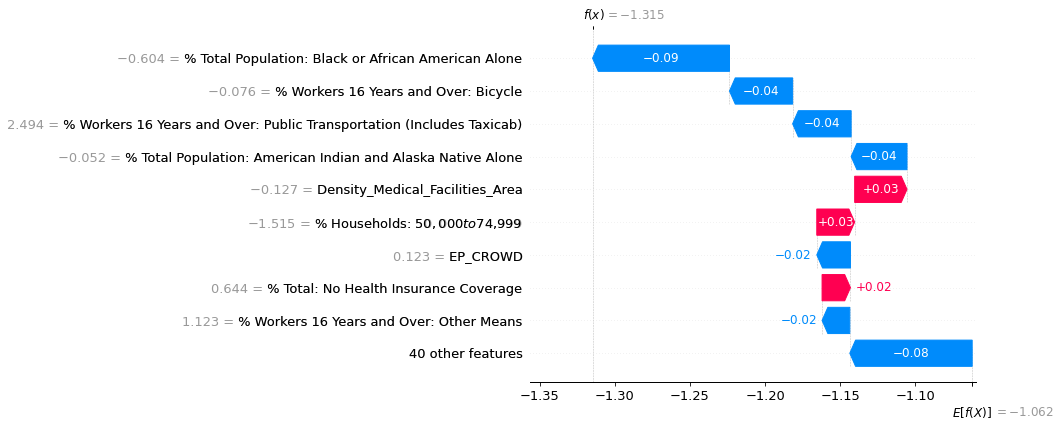

In [32]:
# Plot the SHAP values for a single prediction
shap.plots.waterfall(shap_values[0])

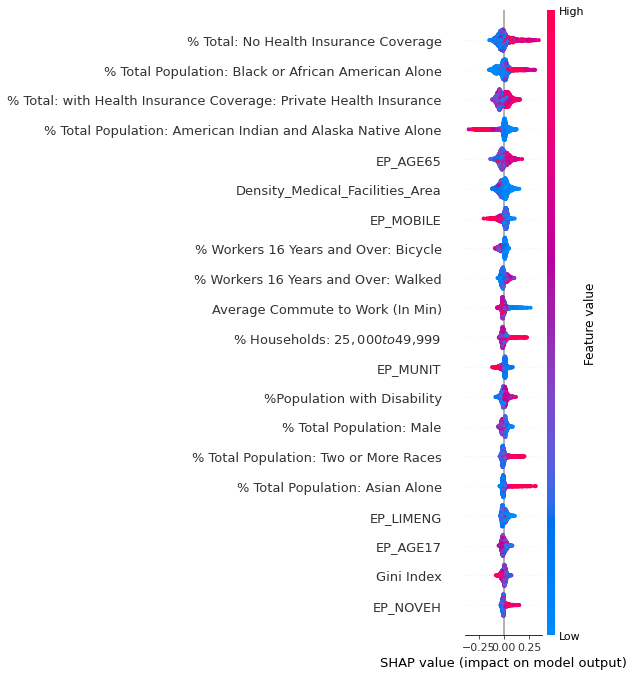

In [33]:
# Plot the SHAP values for the whole dataset
shap.summary_plot(shap_values, X)

In [34]:
# Rank features based on their mean absolute SHAP value
shap_importance = pd.DataFrame({'feature': X.columns, 'importance': np.abs(shap_values.values).mean(0)})
shap_importance = shap_importance.sort_values('importance', ascending=False)

In [35]:
# Print the top 20 ranked features
shap_importance_top20 = shap_importance.head(20)
shap_importance_top20

,feature,importance
18,% Total: No Health Insurance Coverage,0.046522
47,% Total Population: Black or African American ...,0.043278
48,% Total: with Health Insurance Coverage: Priva...,0.042372
1,% Total Population: American Indian and Alaska...,0.034845
20,EP_AGE65,0.032508
44,Density_Medical_Facilities_Area,0.030754
25,EP_MOBILE,0.026533
15,% Workers 16 Years and Over: Bicycle,0.020919
16,% Workers 16 Years and Over: Walked,0.020716
41,Average Commute to Work (In Min),0.020263


In [36]:
# Select the top k features (e.g., top 25 features)
k = 20
top_k_features = shap_importance['feature'].head(k).tolist()

In [37]:
# Print the top k features
print("\nTop", k, "features:")
print(top_k_features)


Top 20 features:
['% Total: No Health Insurance Coverage', '% Total Population: Black or African American Alone', '% Total: with Health Insurance Coverage: Private Health Insurance', '% Total Population: American Indian and Alaska Native Alone', 'EP_AGE65', 'Density_Medical_Facilities_Area', 'EP_MOBILE', '% Workers 16 Years and Over: Bicycle', '% Workers 16 Years and Over: Walked', 'Average Commute to Work (In Min)', '% Households: $25,000 to $49,999', 'EP_MUNIT', '%Population with Disability', '% Total Population: Male', '% Total Population: Two or More Races', '% Total Population: Asian Alone', 'EP_LIMENG', 'EP_AGE17', 'Gini Index', 'EP_NOVEH']


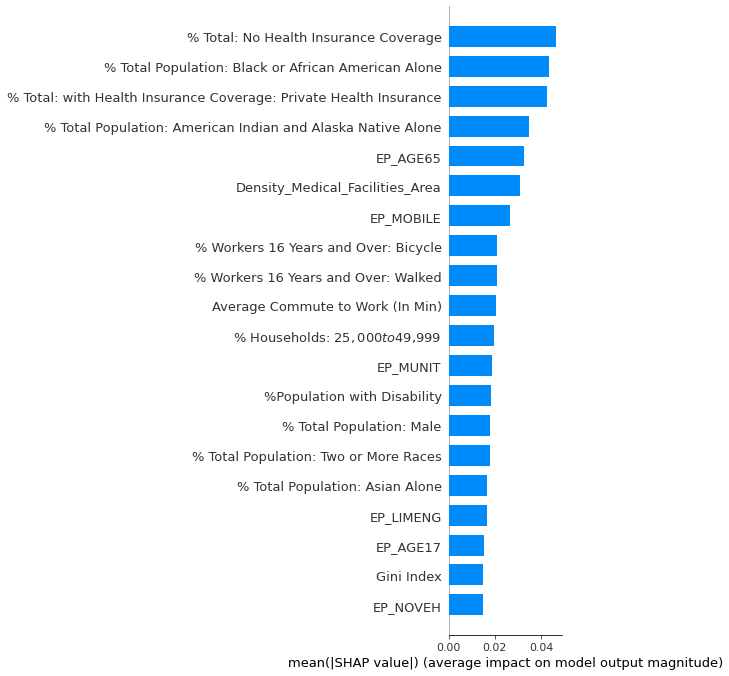

In [38]:
# Plot the SHAP values for the whole dataset
shap.summary_plot(shap_values, X, plot_type="bar")

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


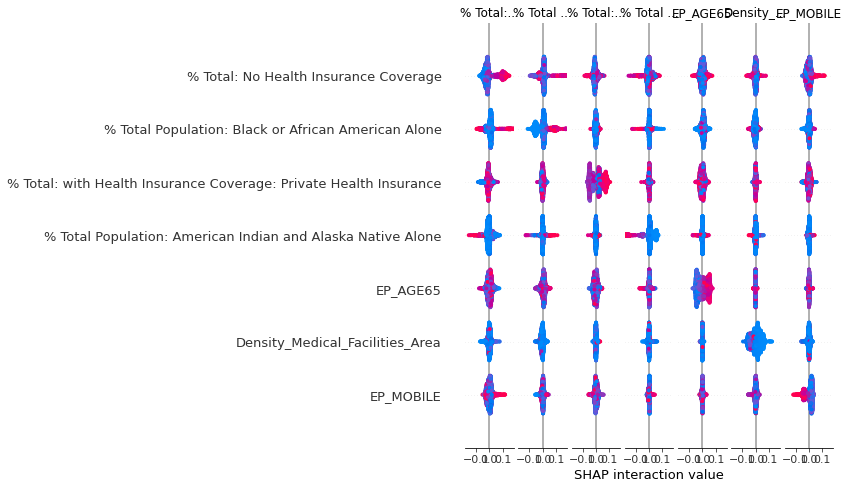

In [39]:

shap_interaction_values = shap.TreeExplainer(best_model).shap_interaction_values(X)

shap.summary_plot(shap_interaction_values, X)

In [40]:
#for name in X.columns:
    #shap.dependence_plot(name, shap_values, X, display_features=X)

In [41]:
# Calculate the mean absolute SHAP interaction values across all instances
mean_abs_shap_interaction_values = np.mean(np.abs(shap_interaction_values), axis=0)

In [42]:
# Set the diagonal values to zero as they represent the main effect of a feature, not the interaction
np.fill_diagonal(mean_abs_shap_interaction_values, 0)

In [43]:
# Get indices of the upper triangle of the mean_abs_shap_interaction_values matrix
upper_triangle_indices = np.triu_indices(mean_abs_shap_interaction_values.shape[0], k=1)

In [44]:
# Get the top 10 interaction indices from the upper triangle part of the matrix
top_10_indices = np.argsort(mean_abs_shap_interaction_values[upper_triangle_indices])[-10:]

In [45]:
# Get the row and column indices of the top 10 interactions
top_10_row_indices, top_10_col_indices = upper_triangle_indices[0][top_10_indices], upper_triangle_indices[1][top_10_indices]

Top interaction 1: '% Households: $25,000 to $49,999' and '% Total: with Health Insurance Coverage: Private Health Insurance'


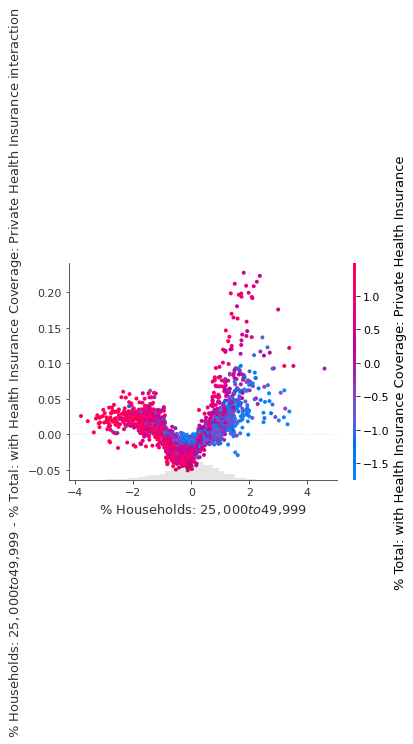

Top interaction 2: '% Total Population: Two or More Races' and '% Total: No Health Insurance Coverage'


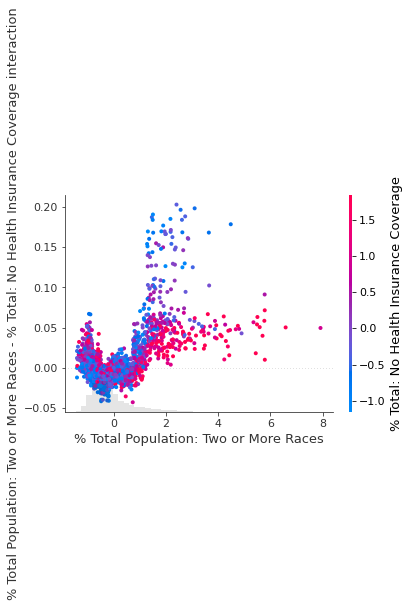

Top interaction 3: '%Population with Disability' and '% Total: with Health Insurance Coverage: Private Health Insurance'


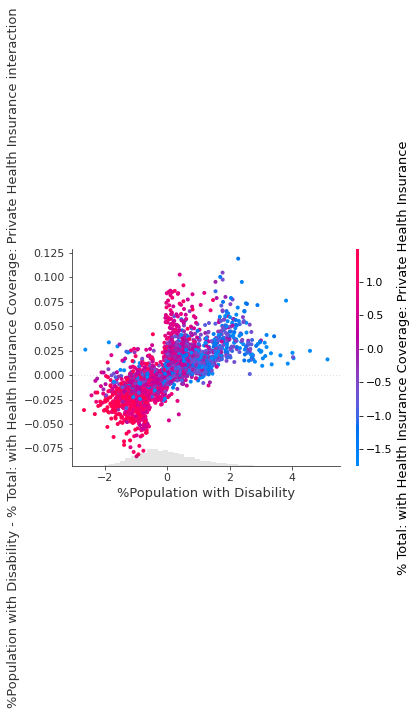

Top interaction 4: 'EP_AGE65' and '% Total: with Health Insurance Coverage: Private Health Insurance'


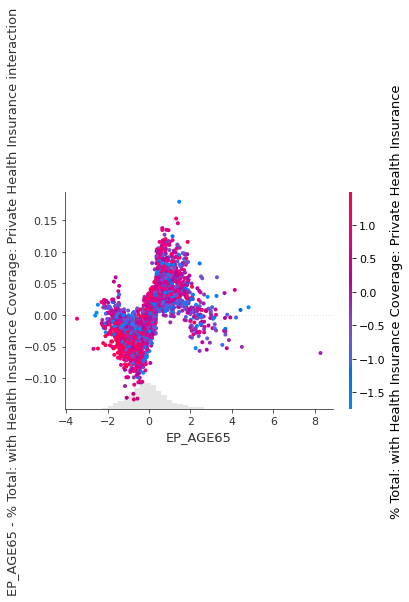

Top interaction 5: 'EP_AGE65' and '% Total Population: Black or African American Alone'


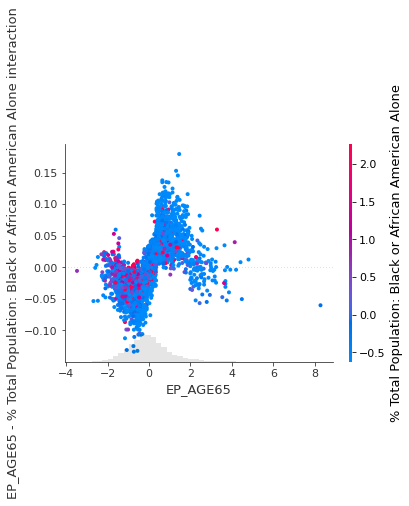

Top interaction 6: '% Total: No Health Insurance Coverage' and 'EP_MOBILE'


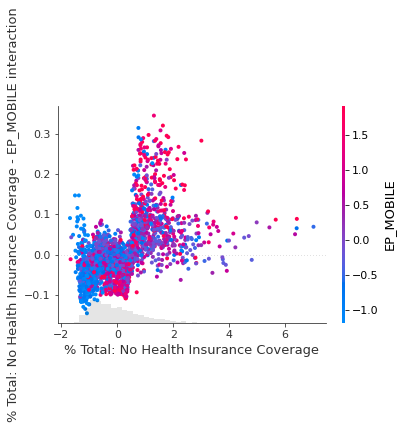

Top interaction 7: '% Total: No Health Insurance Coverage' and '% Total: with Health Insurance Coverage: Private Health Insurance'


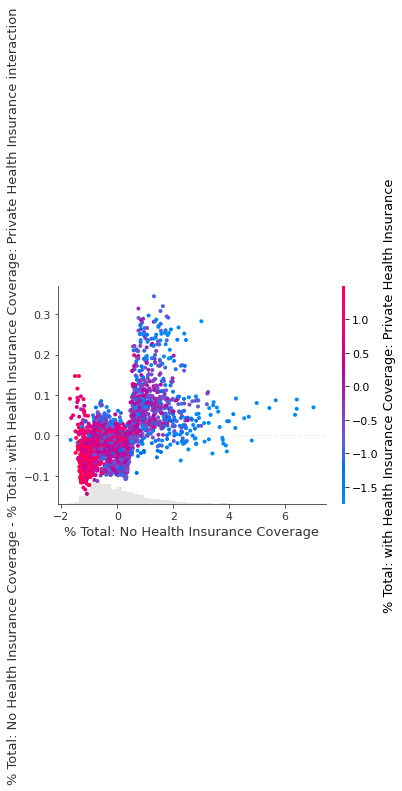

Top interaction 8: '% Total: No Health Insurance Coverage' and 'EP_AGE65'


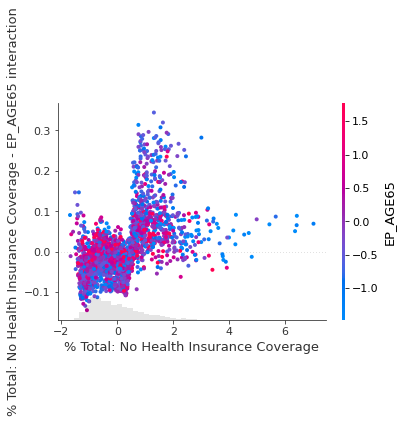

Top interaction 9: '% Total Population: American Indian and Alaska Native Alone' and '% Total: No Health Insurance Coverage'


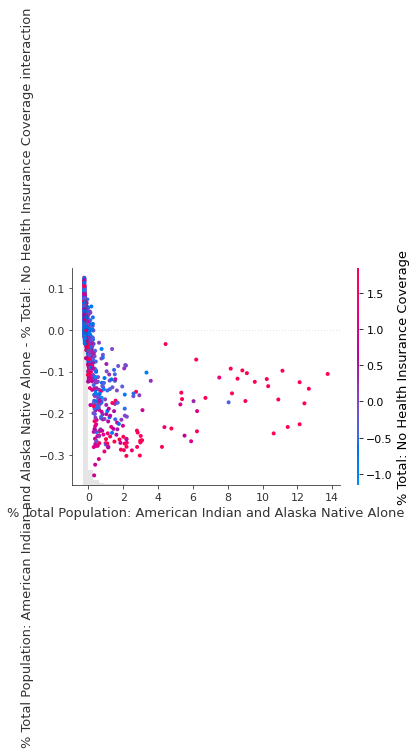

Top interaction 10: '% Total: No Health Insurance Coverage' and '% Total Population: Black or African American Alone'


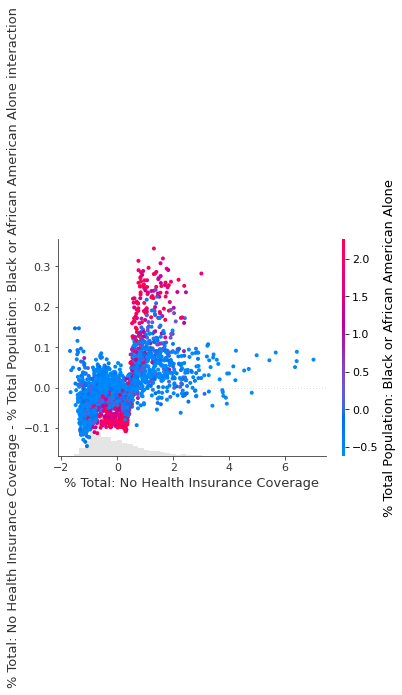

In [46]:
# Print the top 10 pairs of interacting features
for i, (feature_1_index, feature_2_index) in enumerate(zip(top_10_row_indices, top_10_col_indices)):
    feature_1 = X.columns[feature_1_index]
    feature_2 = X.columns[feature_2_index]
    print(f"Top interaction {i + 1}: '{feature_1}' and '{feature_2}'")

    # Plot the interaction between the selected features using shap.plots.scatter
    fig, ax = plt.subplots()
    shap.plots.scatter(shap_values[:, feature_1_index], color=shap_values[:, feature_2_index], ax=ax, show=False)
    ax.set_xlabel(feature_1)
    ax.set_ylabel(f"{feature_1} - {feature_2} interaction")
    plt.show()

In [47]:
# Print the top 10 pairs of interacting features and their Pearson correlation coefficients
for i, (feature_1_index, feature_2_index) in enumerate(zip(top_10_row_indices, top_10_col_indices)):
    feature_1 = X.columns[feature_1_index]
    feature_2 = X.columns[feature_2_index]
    pearson_coeff, _ = scipy.stats.pearsonr(X[feature_1], X[feature_2])

    print(f"Top interaction {i + 1}: '{feature_1}' and '{feature_2}', Pearson correlation coefficient: {pearson_coeff:.2f}")


Top interaction 1: '% Households: $25,000 to $49,999' and '% Total: with Health Insurance Coverage: Private Health Insurance', Pearson correlation coefficient: -0.52
Top interaction 2: '% Total Population: Two or More Races' and '% Total: No Health Insurance Coverage', Pearson correlation coefficient: 0.31
Top interaction 3: '%Population with Disability' and '% Total: with Health Insurance Coverage: Private Health Insurance', Pearson correlation coefficient: -0.56
Top interaction 4: 'EP_AGE65' and '% Total: with Health Insurance Coverage: Private Health Insurance', Pearson correlation coefficient: -0.09
Top interaction 5: 'EP_AGE65' and '% Total Population: Black or African American Alone', Pearson correlation coefficient: -0.19
Top interaction 6: '% Total: No Health Insurance Coverage' and 'EP_MOBILE', Pearson correlation coefficient: 0.36
Top interaction 7: '% Total: No Health Insurance Coverage' and '% Total: with Health Insurance Coverage: Private Health Insurance', Pearson correla

In [48]:
# Get the top 10 interacting feature pairs
top_interacting_pairs = [(X.columns[row_index], X.columns[col_index]) for row_index, col_index in zip(top_10_row_indices, top_10_col_indices)]

In [49]:
for feature_1, feature_2 in top_interacting_pairs:
    feature_1_index = X.columns.get_loc(feature_1)
    feature_2_index = X.columns.get_loc(feature_2)
    
    # Calculate the Spearman's rank correlation coefficient
    spearman_corr, spearman_pvalue = spearmanr(X[feature_1], X[feature_2])
    
    # Calculate Kendall's tau
    kendall_tau, kendall_pvalue = kendalltau(X[feature_1], X[feature_2])
    
    print(f"Spearman correlation between {feature_1} and {feature_2}: {spearman_corr:.2f} (p-value: {spearman_pvalue:.2e})")
    print(f"Kendall's tau between {feature_1} and {feature_2}: {kendall_tau:.2f} (p-value: {kendall_pvalue:.2e})")
    print()


Spearman correlation between % Households: $25,000 to $49,999 and % Total: with Health Insurance Coverage: Private Health Insurance: -0.54 (p-value: 1.00e-227)
Kendall's tau between % Households: $25,000 to $49,999 and % Total: with Health Insurance Coverage: Private Health Insurance: -0.38 (p-value: 2.38e-216)

Spearman correlation between % Total Population: Two or More Races and % Total: No Health Insurance Coverage: 0.20 (p-value: 1.62e-29)
Kendall's tau between % Total Population: Two or More Races and % Total: No Health Insurance Coverage: 0.14 (p-value: 1.51e-29)

Spearman correlation between %Population with Disability and % Total: with Health Insurance Coverage: Private Health Insurance: -0.61 (p-value: 1.11e-303)
Kendall's tau between %Population with Disability and % Total: with Health Insurance Coverage: Private Health Insurance: -0.44 (p-value: 9.60e-293)

Spearman correlation between EP_AGE65 and % Total: with Health Insurance Coverage: Private Health Insurance: -0.11 (p-

# Train the model with the most important features on the county level

In [50]:
# Filter the dataset to only include the top k important features
X_filtered = X[top_k_features]

In [51]:
# Create a KFold cross-validator
cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [52]:
# Create the custom scoring functions
scoring = {
    'mae': make_scorer(mean_absolute_error),
    'mse': make_scorer(mean_squared_error),
    'r2': make_scorer(r2_score)
}

In [53]:
# Train an XGBoost model with the top k features using cross-validation
model_filtered = xgb.XGBRegressor()
cv_results = cross_validate(model_filtered, X_filtered, y, cv=cv, scoring=scoring, return_train_score=True)

In [54]:
# Print the evaluation metrics for each fold
for i, (train_index, test_index) in enumerate(cv.split(X_filtered, y)):
    print(f"Fold {i + 1}:")
    print(f"  Train MAE: {cv_results['train_mae'][i]:.2f}, Test MAE: {cv_results['test_mae'][i]:.2f}")
    print(f"  Train MSE: {cv_results['train_mse'][i]:.2f}, Test MSE: {cv_results['test_mse'][i]:.2f}")
    print(f"  Train R2: {cv_results['train_r2'][i]:.2f}, Test R2: {cv_results['test_r2'][i]:.2f}")

Fold 1:
  Train MAE: 0.03, Test MAE: 0.33
  Train MSE: 0.00, Test MSE: 0.19
  Train R2: 0.99, Test R2: 0.14
Fold 2:
  Train MAE: 0.03, Test MAE: 0.33
  Train MSE: 0.00, Test MSE: 0.18
  Train R2: 0.99, Test R2: 0.18
Fold 3:
  Train MAE: 0.04, Test MAE: 0.33
  Train MSE: 0.00, Test MSE: 0.18
  Train R2: 0.99, Test R2: 0.14
Fold 4:
  Train MAE: 0.04, Test MAE: 0.33
  Train MSE: 0.00, Test MSE: 0.18
  Train R2: 0.99, Test R2: 0.18
Fold 5:
  Train MAE: 0.04, Test MAE: 0.34
  Train MSE: 0.00, Test MSE: 0.19
  Train R2: 0.99, Test R2: 0.14


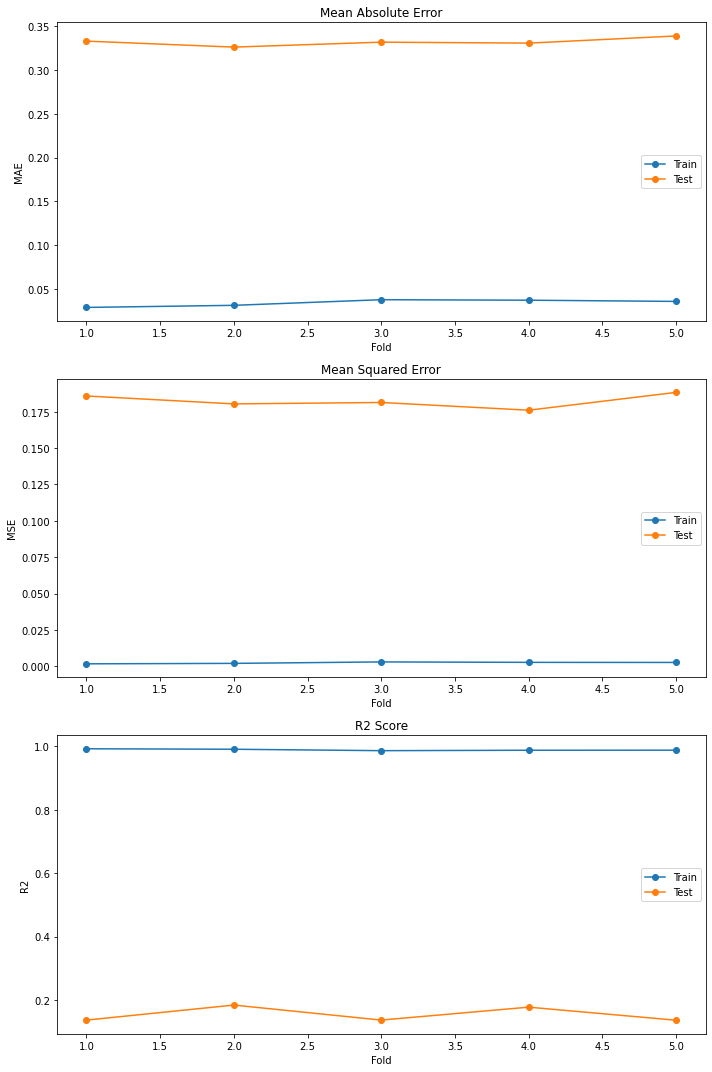

In [55]:
# Plot the evaluation metrics for each fold
folds = np.arange(1, len(cv_results['train_mae']) + 1)

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

# MAE plot
axes[0].plot(folds, cv_results['train_mae'], marker='o', label='Train')
axes[0].plot(folds, cv_results['test_mae'], marker='o', label='Test')
axes[0].set_title('Mean Absolute Error')
axes[0].set_xlabel('Fold')
axes[0].set_ylabel('MAE')
axes[0].legend()

# MSE plot
axes[1].plot(folds, cv_results['train_mse'], marker='o', label='Train')
axes[1].plot(folds, cv_results['test_mse'], marker='o', label='Test')
axes[1].set_title('Mean Squared Error')
axes[1].set_xlabel('Fold')
axes[1].set_ylabel('MSE')
axes[1].legend()

# R2 plot
axes[2].plot(folds, cv_results['train_r2'], marker='o', label='Train')
axes[2].plot(folds, cv_results['test_r2'], marker='o', label='Test')
axes[2].set_title('R2 Score')
axes[2].set_xlabel('Fold')
axes[2].set_ylabel('R2')
axes[2].legend()

plt.tight_layout()
plt.show()

In [56]:
# Train the filtered model on the whole dataset to use for tract-level predictions
model_filtered.fit(X_filtered, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

# Predict on the tract level

## Preprocessing

In [57]:
# Read the tract file
df_tract=pd.read_csv('df_tracts.csv')

In [58]:
df_tract["Stops_per_Facility"].replace([-np.inf],np.nan, inplace=True)
df_tract["Density_Medical_Facilities_Population"].replace([-np.inf],np.nan, inplace=True)
df_tract["Density_Medical_Facilities_Area"].replace([-np.inf],np.nan, inplace=True)
df_tract["Density_Transportation_Stops_Pop"].replace([np.inf],np.nan, inplace=True)
df_tract["Density_Transportation_Stops_Area"].replace([np.inf],np.nan, inplace=True)

In [59]:
df_tract[np.isinf(df_tract).any(axis=1)]

,FIPS,Population Density (Per Sq. Mile),Area (Land),Average Commute to Work (In Min),AREA_SQMI,Density_Medical_Facilities_Population,Density_Medical_Facilities_Area,Density_Transportation_Stops_Pop,Density_Transportation_Stops_Area,Stops_per_Facility,...,%Total Child Population,%Total University,%Total High school,%Total Less than High School,%Total Adult Population,%Total Elderly Population,%Population with Disability,%LIMENG,%NOINT,%DAYPOP
1058,56021980801,0.0000,3620472,NaN,1.397871,NaN,0.0,NaN,0.000000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
1186,55139001700,551.8555,25545281,19.0,9.863084,0.0,0.0,0.000724,0.405553,inf,...,0.154694,0.446664,0.411184,0.139568,0.753077,0.092229,0.066799,0.003440,0.024620,1.105177
1188,55139001500,2385.8330,3357667,18.0,1.296402,0.0,0.0,0.002269,5.399560,inf,...,0.264468,0.631928,0.302700,0.055424,0.610087,0.125445,0.133225,0.004538,0.128363,2.168558
1189,55139001400,1465.3860,6286797,14.0,2.427345,0.0,0.0,0.003374,4.943673,inf,...,0.191735,0.465679,0.445788,0.084633,0.608097,0.200169,0.112735,0.000000,0.052572,0.828226
1193,55139001000,2774.8930,2242876,16.0,0.865979,0.0,0.0,0.005995,17.321438,inf,...,0.121099,0.594676,0.330309,0.061101,0.661257,0.217645,0.200240,0.007194,0.066747,0.621103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84278,1073001100,1401.9090,10140773,22.0,3.915373,0.0,0.0,0.005664,6.895895,inf,...,0.182729,0.621411,0.291387,0.087202,0.615595,0.201676,0.173484,0.018880,0.062094,0.503461
84280,1073000700,1541.9730,3520565,22.0,1.359297,0.0,0.0,0.013346,21.334555,inf,...,0.423664,0.400746,0.332712,0.266542,0.430821,0.145515,0.357570,0.000000,0.405890,0.871606
84281,1073000500,1740.8030,4680657,23.0,1.807211,0.0,0.0,0.009437,16.046825,inf,...,0.315957,0.401124,0.391415,0.193153,0.561030,0.123013,0.210543,0.008461,0.369346,0.640417
84282,1073000400,1023.5270,7998768,20.0,3.088340,0.0,0.0,0.006965,7.447366,inf,...,0.241379,0.500000,0.317818,0.176176,0.671623,0.086998,0.234403,0.008783,0.199273,1.314658


In [60]:
df_tract.replace([np.inf], np.nan, inplace=True)

In [61]:
df_tract.dropna(inplace=True)

In [62]:
df_tract["% Total: No Health Insurance Coverage"] = df_tract["% Total: No Health Insurance Coverage"].astype(float)/100

In [63]:
# Scale the data using the same scaler of the county df 
df_tract1=df_tract.copy()
df_tract[spatial+socioeconomic] = scaler.fit_transform(df_tract[spatial+socioeconomic])

## Model

In [64]:
# Filter the tract-level dataset to only include the top k important features
X_tract_filtered = df_tract[top_k_features]

In [65]:
# Use the trained model to make predictions on the filtered tract-level dataset
y_tract_pred_filtered = model_filtered.predict(X_tract_filtered)

In [66]:
# Store the predictions in a new column or DataFrame
df_tract['predicted_index'] = y_tract_pred_filtered

In [67]:
# Remove the log 
df_tract['predicted_index']=df_tract['predicted_index'].apply(np.exp)

# Validation of the tract model by aggregating on the county level

In [68]:
# transform the FIPS column to string to extract the County FIPS
df_tract['FIPS']=df_tract['FIPS'].astype(str)

In [69]:
# check if any cell length is less than or equal to 11

is_length_less_than_11 = df_tract['FIPS'].apply(lambda x: len(x) < 11).any()

print(is_length_less_than_11)  # output: True

True


In [70]:
# add leading zeros to cell values with length less than 11
df_tract['FIPS'] = df_tract['FIPS'].apply(lambda x: x.zfill(11) if len(x) < 11 else x)

In [71]:
# check if any cell length is less than or greater than 11
is_length_less_or_greater_than_11 = df_tract['FIPS'].apply(lambda x: len(x) < 11 or len(x) > 11).any()

print(is_length_less_or_greater_than_11)  # output: True

False


In [72]:
# display rows where FIPS value length is greater than 11
threshold = 11
result = df_tract[df_tract['FIPS'].str.len() > threshold]
result

,FIPS,Population Density (Per Sq. Mile),Area (Land),Average Commute to Work (In Min),AREA_SQMI,Density_Medical_Facilities_Population,Density_Medical_Facilities_Area,Density_Transportation_Stops_Pop,Density_Transportation_Stops_Area,Stops_per_Facility,...,%Total University,%Total High school,%Total Less than High School,%Total Adult Population,%Total Elderly Population,%Population with Disability,%LIMENG,%NOINT,%DAYPOP,predicted_index


In [73]:
# define a lambda function to extract county code from FIPS code
get_county_code = lambda x: x[:5]

In [74]:
# apply the lambda function to FIPS column and create a new county code column
df_tract['County_Code'] = df_tract['FIPS'].apply(get_county_code)

In [75]:
# transform the county code column to integer for join
df_tract['County_Code']=df_tract['County_Code'].astype(int)

In [76]:
# Create a new column for the product of population and the index value for each tract
df_tract['pop_index_product'] = df_tract['Total Population'] * df_tract['predicted_index']

In [77]:
# Group the DataFrame by the county code and calculate the sum of the population and the product of population and index for each county
county_mean_df = df_tract.groupby('County_Code').agg({'Total Population': 'sum', 'pop_index_product': 'sum'}).reset_index()

In [78]:
# Calculate the weighted average index for each county using the aggregated sums
county_mean_df['weighted_index'] = county_mean_df['pop_index_product'] / county_mean_df['Total Population']

In [79]:
# Select the columns to use
county_mean_df = county_mean_df[['County_Code','weighted_index']]

In [80]:
# Rename columns
county_mean_df.columns = ['FIPS', 'Average_Index_Tract']

In [81]:
# Perform the left join based on the 'FIPS' column
df_scaled = df_scaled.merge(county_mean_df, on='FIPS', how='left')

In [82]:
# Put back the log on the aggregated values from the tract
df_scaled['Average_Index_Tract']=df_scaled['Average_Index_Tract'].apply(np.log)

In [83]:
# Extract the actual and aggregated index values as separate lists or arrays
actual_index = df_scaled['IDX_W2M'].values
aggregated_index = df_scaled['Average_Index_Tract'].values

In [84]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(actual_index, aggregated_index)

In [85]:
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(actual_index, aggregated_index)

In [86]:
# Calculate Mean Squared Error (MSE)
mape = mean_absolute_percentage_error(actual_index, aggregated_index)

In [87]:
# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

In [88]:
# Print the results
print(f'Mean Absolute Error (MAE): {mae.round(2)}')
print(f'Mean Squared Error (MSE): {mse.round(2)}')
print(f'Root Mean Squared Error (RMSE): {rmse.round(2)}')

Mean Absolute Error (MAE): 0.36
Mean Squared Error (MSE): 0.21
Root Mean Squared Error (RMSE): 0.46


# Equity metrics calculation As-Is

## Gini index

In [89]:
# Gini calculation
gini_index = gini_coefficient(df_tract['predicted_index'])
print(f"Gini Index: {gini_index:.4f}")

Gini Index: 0.1613


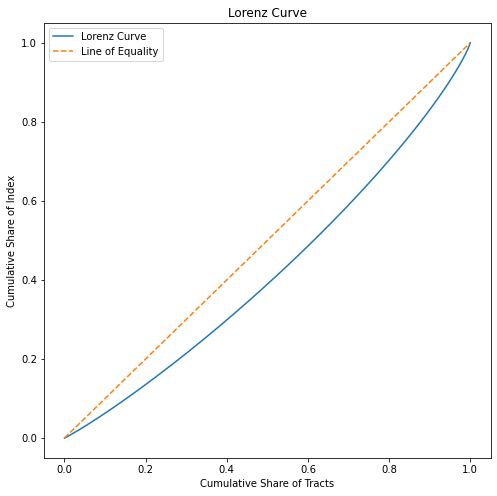

In [90]:
#Lorenz curves
index_values = df_tract['predicted_index']

lorenz_values = lorenz_curve(index_values)

plt.figure(figsize=(8, 8))
plt.plot(np.linspace(0, 1, len(lorenz_values)), lorenz_values, label="Lorenz Curve")
plt.plot([0, 1], [0, 1], linestyle="--", label="Line of Equality")
plt.xlabel("Cumulative Share of Tracts")
plt.ylabel("Cumulative Share of Index")
plt.title("Lorenz Curve")
plt.legend()
plt.show()

## Theil Index

### Theil Index calculation

In [91]:
#Theil calculation
theil_index = theil_index(df_tract['predicted_index'])
print(f"Theil Index: {theil_index:.4f}")

Theil Index: 0.0441


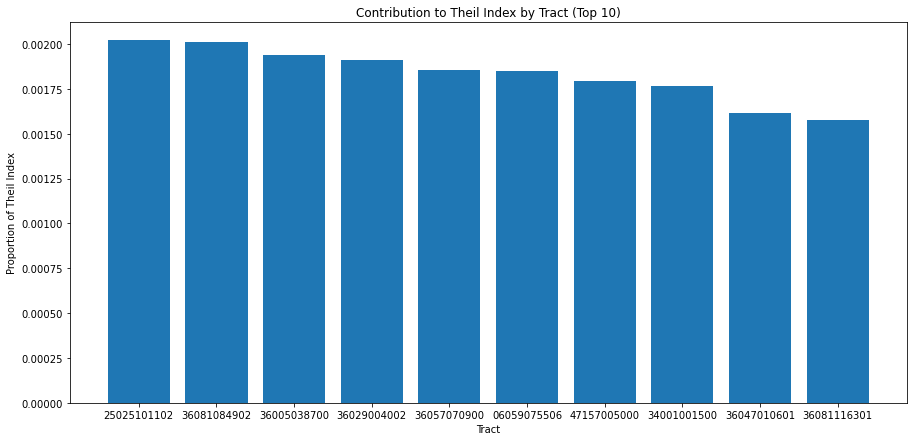

In [92]:
#Contribution to Theil index
index_values = df_tract['predicted_index']
theil_contribs = theil_contributions(index_values)
total_theil = np.sum(theil_contribs)

# Sort the tracts based on their contribution to the Theil index
sorted_indices = np.argsort(theil_contribs)[::-1][:10]  # Get the indices of the top 10 tracts

# Select the top 10 contributing tracts
top_tracts = df_tract['FIPS'].iloc[sorted_indices]
top_contribs = theil_contribs[sorted_indices]

# Plot the top 10 contributing tracts
plt.figure(figsize=(15, 7))
plt.bar(top_tracts, top_contribs / total_theil)
plt.xlabel('Tract')
plt.ylabel('Proportion of Theil Index')
plt.title('Contribution to Theil Index by Tract (Top 10)')
plt.show()

### Tract Clustering based on Theil contributions

In [93]:
# Add Theil contributions to the DataFrame
df_tract['Theil_contribs'] = theil_contribs

In [94]:
# Determine the optimal number of clusters using the Elbow method
inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_tract[['Theil_contribs']])
    inertia.append(kmeans.inertia_)

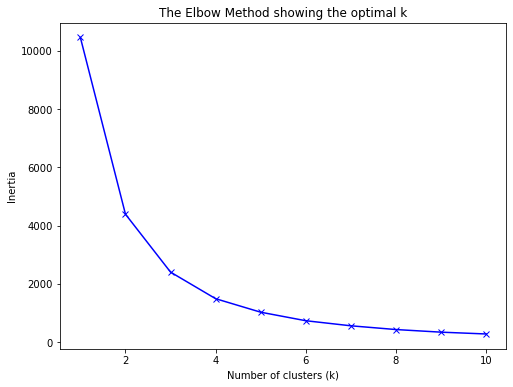

In [95]:
# Plot the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(K, inertia, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [96]:
# Set the optimal number of clusters based on the Elbow Method
optimal_k = 8  # 8 is the point where the decrease in inertia becomes less significant according to the elbow curve.

In [97]:
# Perform KMeans clustering
kmeans = KMeans(n_clusters=optimal_k)
df_tract['Cluster'] = kmeans.fit_predict(df_tract[['Theil_contribs']])

In [98]:
# Calculate cluster centroids
cluster_centroids = kmeans.cluster_centers_

In [99]:
# Create a DataFrame with the cluster centroids
centroid_df = pd.DataFrame(cluster_centroids, columns=['Average_contribution'])
centroid_df['Cluster'] = np.arange(optimal_k)

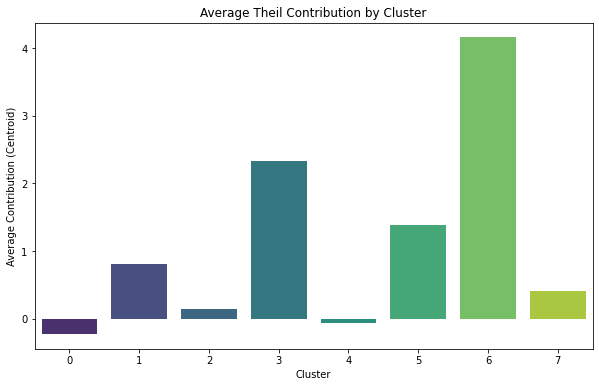

In [100]:
# Plot the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='Average_contribution', data=centroid_df, palette='viridis')
plt.xlabel('Cluster')
plt.ylabel('Average Contribution (Centroid)')
plt.title('Average Theil Contribution by Cluster')
plt.show()

### Visualization of clusters in Massachussets

In [101]:
# Read the tract file for Massachussets
gdf = gpd.read_file('tl_2022_25_tract.shp') #Massachussets state only

In [102]:
# Transform the FIPS column for join
df_tract['FIPS']=df_tract['FIPS'].astype(str)

In [103]:
# Select the columns used for visualization
df_viz=df_tract[['FIPS','Cluster']]

In [104]:
# Rename the column for join in the tract file
gdf = gdf.rename(columns={'GEOID': 'FIPS'})

In [105]:
# Join the two dataframes
gdf['FIPS'] = gdf['FIPS'].astype(str) # Ensure FIPS codes are of the same data type
merged_gdf = gdf.merge(df_viz, on='FIPS', how='inner')

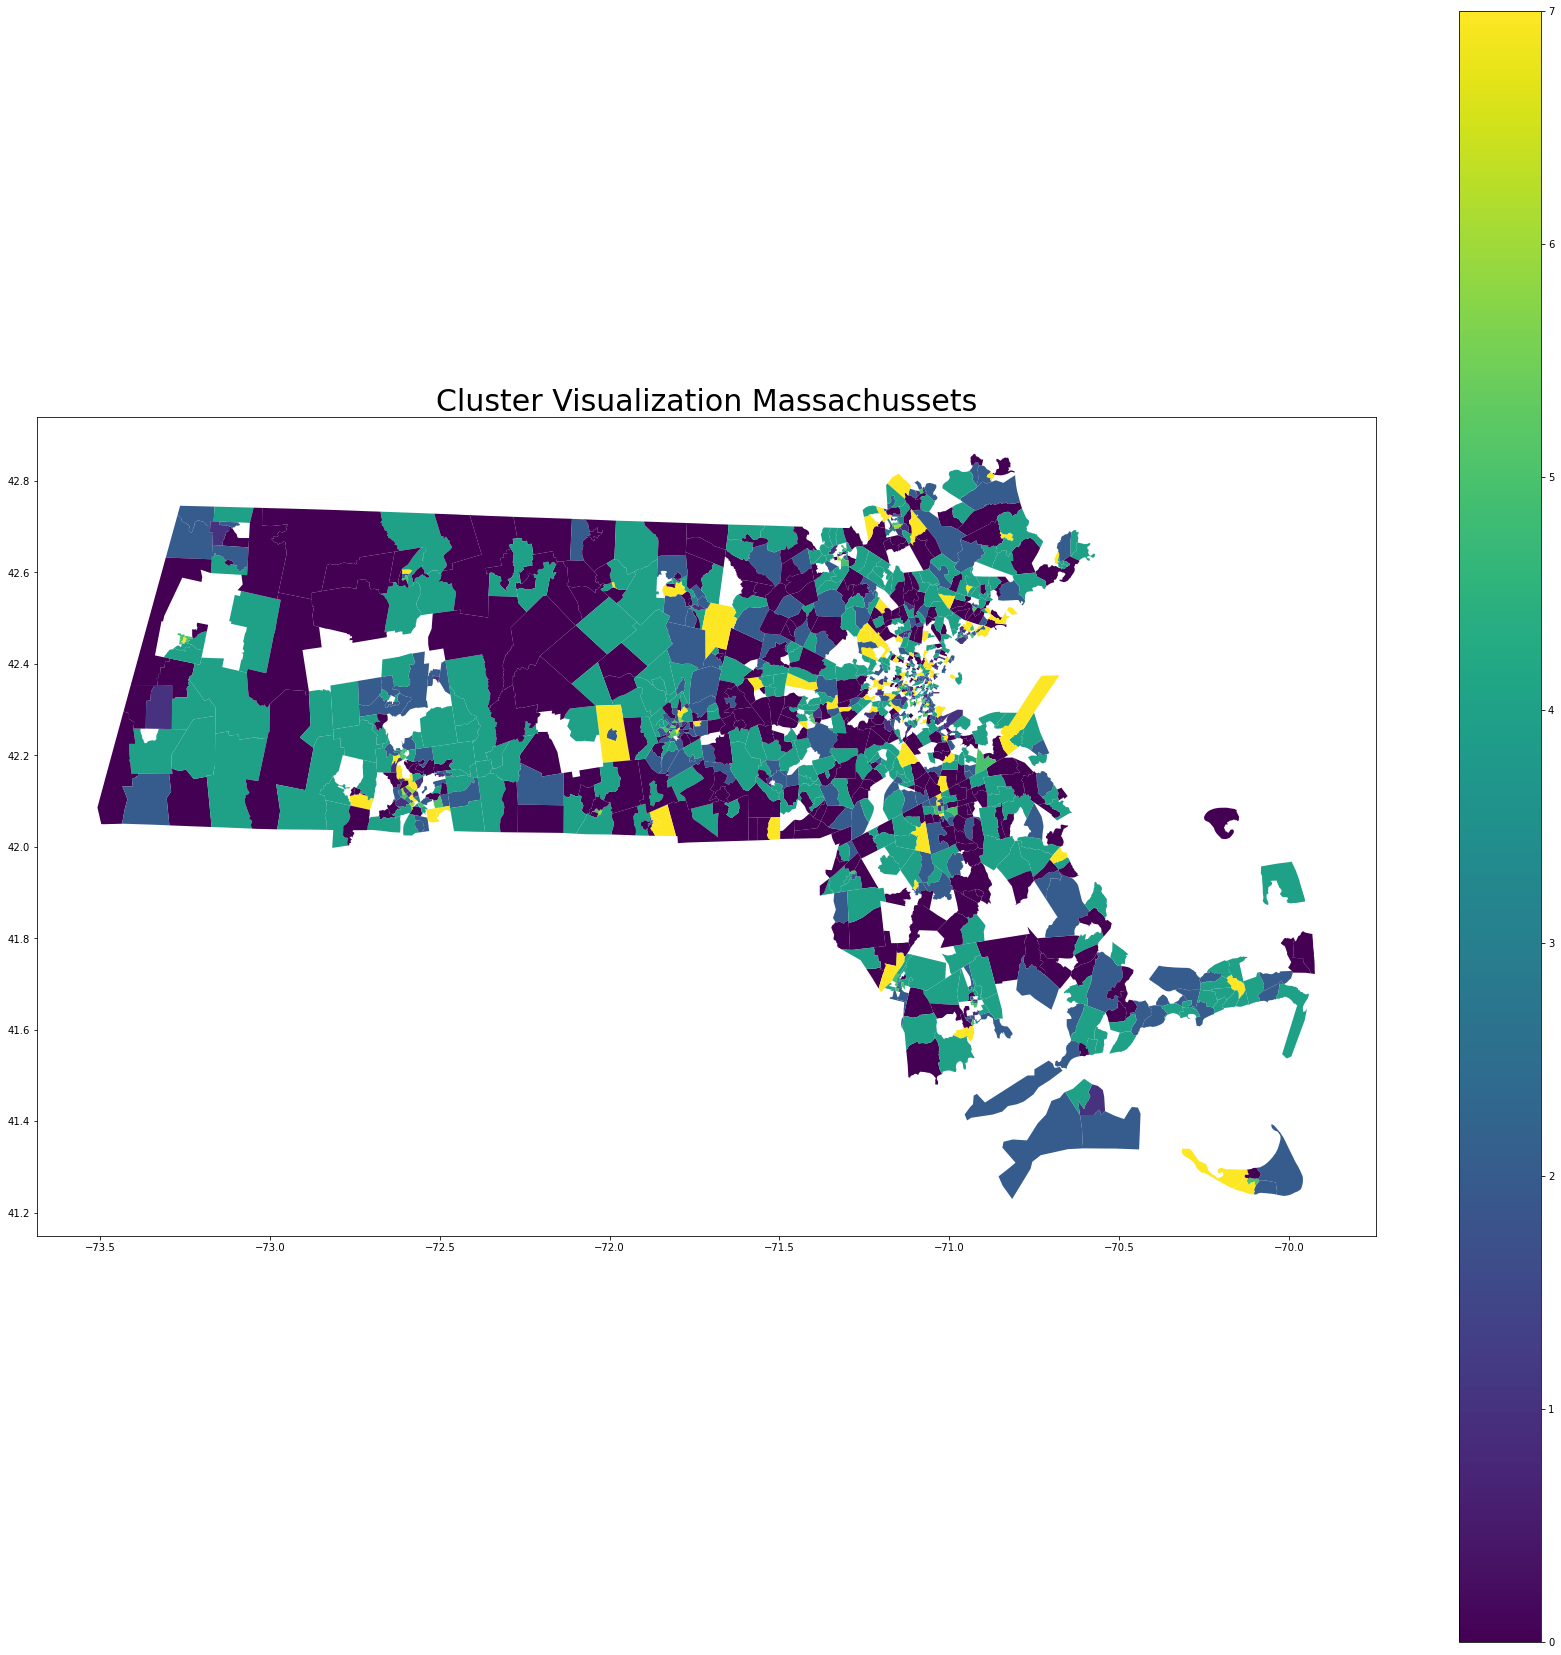

In [106]:
# Plot the clusters on the map
fig, ax = plt.subplots(figsize=(30, 30))
merged_gdf.plot(column='Cluster', cmap='viridis', legend=True, ax=ax)
plt.title('Cluster Visualization Massachussets',fontsize=30)
plt.show()

# Simulation

In [107]:
# Define the range of increase percentages to 100%
increase_percentages = np.linspace(0.01, 1.0, num=100)

## Simulation with equality

In [108]:
# Initialize empty lists to store the results
gini_indices = []
simul_indices = []


In [109]:
# Loop through each increase percentage
for increase_percentage in increase_percentages:
    # Make a copy of the original DataFrame
    X_tract_simul = X_tract_filtered.copy()
    # Increase the Density_Medical_Facilities_Area by the current percentage
    X_tract_simul['Density_Medical_Facilities_Area'] *= (1 + increase_percentage)
    # Use the trained model to make predictions on the filtered tract-level dataset
    y_tract_pred_simul = model_filtered.predict(X_tract_simul)
    # Store the predictions in a new column or DataFrame
    simul_indices.append(np.exp(y_tract_pred_simul))
    # Remove the log
    y_tract_pred_simul = np.exp(y_tract_pred_simul)
    # Compute the Gini index on the simulation
    gini_index = gini_coefficient(y_tract_pred_simul)
    # Store the Gini index in the list
    gini_indices.append(gini_index)

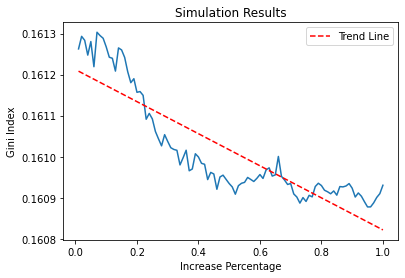

In [110]:
# Plot the results
fig, ax = plt.subplots()
ax.plot(increase_percentages, gini_indices)
ax.set_xlabel('Increase Percentage')
ax.set_ylabel('Gini Index')
ax.set_title('Simulation Results')
# Fit a polynomial of degree 1 (linear trend line) to the data
z = np.polyfit(increase_percentages, gini_indices, 1)
trend_line = np.poly1d(z)
# Plot the trend line
ax.plot(increase_percentages, trend_line(increase_percentages), 'r--', label='Trend Line')
ax.legend()
# Show the plot
plt.show()

## Simulation with proportional increase based on population density

In [111]:
# Add columns for simulation
columns_simul=top_k_features+ ['Population Density (Per Sq. Mile)']

In [112]:
# Initialize empty lists to store the results
gini_indices_1 = []
simul_indices_1 = []

In [113]:
# Loop through each increase percentage
for increase_percentage in increase_percentages:
    # Create the dataframe
    df_tract_simul=df_tract[columns_simul]
    # Calculate the proportional increase for each tract
    proportional_increase = df_tract_simul['Population Density (Per Sq. Mile)'] * increase_percentage
    # Increase the Density_Medical_Facilities_Area by the current percentage
    df_tract_simul['Density_Medical_Facilities_Area'] *= (1 + proportional_increase)
    # Define X
    X_tract_simul= df_tract_simul[top_k_features]
    # Use the trained model to make predictions on the filtered tract-level dataset
    y_tract_pred_simul = model_filtered.predict(X_tract_simul)
    # Store the predictions in a new column or DataFrame
    simul_indices_1.append(np.exp(y_tract_pred_simul))
    # Remove the log
    y_tract_pred_simul = np.exp(y_tract_pred_simul)
    # Compute the Gini index on the simulation
    gini_index = gini_coefficient(y_tract_pred_simul)
    # Store the Gini index in the list
    gini_indices_1.append(gini_index)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

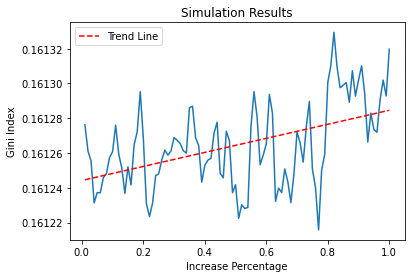

In [114]:
# Plot the results
fig, ax = plt.subplots()
ax.plot(increase_percentages, gini_indices_1)
ax.set_xlabel('Increase Percentage')
ax.set_ylabel('Gini Index')
ax.set_title('Simulation Results')
# Fit a polynomial of degree 1 (linear trend line) to the data
z = np.polyfit(increase_percentages, gini_indices_1, 1)
trend_line = np.poly1d(z)
# Plot the trend line
ax.plot(increase_percentages, trend_line(increase_percentages), 'r--', label='Trend Line')
ax.legend()
# Show the plot
plt.show()

## Simulation with proportional increase based on time to commute to work

In [115]:
# Add columns for simulation
columns_simul_3=top_k_features+ ['Average Commute to Work (In Min)']

In [116]:
# Initialize empty lists to store the results
gini_indices_3 = []
simul_indices_3 = []

In [117]:
# Loop through each increase percentage
for increase_percentage in increase_percentages:
    # Create the dataframe
    df_tract_simul=df_tract[columns_simul]
    # Calculate the proportional increase for each tract
    proportional_increase = df_tract_simul['Average Commute to Work (In Min)'] * increase_percentage
    # Increase the Density_Medical_Facilities_Area by the current percentage
    df_tract_simul['Density_Medical_Facilities_Area'] *= (1 + proportional_increase)
    # Define X
    X_tract_simul= df_tract_simul[top_k_features]
    # Use the trained model to make predictions on the filtered tract-level dataset
    y_tract_pred_simul = model_filtered.predict(X_tract_simul)
    # Store the predictions in a new column or DataFrame
    simul_indices_3.append(np.exp(y_tract_pred_simul))
    # Remove the log
    y_tract_pred_simul = np.exp(y_tract_pred_simul)
    # Compute the Gini index on the simulation
    gini_index = gini_coefficient(y_tract_pred_simul)
    # Store the Gini index in the list
    gini_indices_3.append(gini_index)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

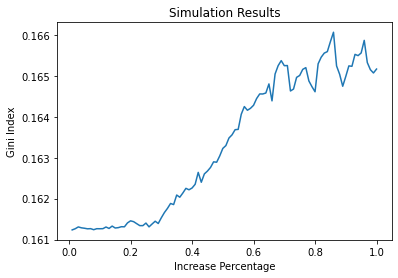

In [118]:
# Plot the results
fig, ax = plt.subplots()
ax.plot(increase_percentages, gini_indices_3)
ax.set_xlabel('Increase Percentage')
ax.set_ylabel('Gini Index')
ax.set_title('Simulation Results')
# Fit a polynomial of degree 1 (linear trend line) to the data
#z = np.polyfit(increase_percentages, gini_indices_3, 1)
#trend_line = np.poly1d(z)
# Plot the trend line
#ax.plot(increase_percentages, trend_line(increase_percentages), 'r--', label='Trend Line')
#ax.legend()
# Show the plot
plt.show()

## Simulation with proportional increase based on population density and time to commute to work

In [119]:
# Add columns for simulation
columns_simul_2=top_k_features+ ['Population Density (Per Sq. Mile)','Average Commute to Work (In Min)']

In [120]:
# Initialize empty lists to store the results
gini_indices_2 = []
simul_indices_2 = []

In [121]:
# Loop through each increase percentage
for increase_percentage in increase_percentages:
    # Create the dataframe
    df_tract_simul=df_tract[columns_simul]
    # Calculate the proportional increase for each tract
    proportional_increase = (df_tract_simul['Population Density (Per Sq. Mile)']+df_tract_simul['Average Commute to Work (In Min)']) * increase_percentage
    # Increase the Density_Medical_Facilities_Area by the current percentage
    df_tract_simul['Density_Medical_Facilities_Area'] *= (1 + proportional_increase)
    # Define X
    X_tract_simul= df_tract_simul[top_k_features]
    # Use the trained model to make predictions on the filtered tract-level dataset
    y_tract_pred_simul = model_filtered.predict(X_tract_simul)
    # Store the predictions in a new column or DataFrame
    simul_indices_2.append(np.exp(y_tract_pred_simul))
    # Remove the log
    y_tract_pred_simul = np.exp(y_tract_pred_simul)
    # Compute the Gini index on the simulation
    gini_index = gini_coefficient(y_tract_pred_simul)
    # Store the Gini index in the list
    gini_indices_2.append(gini_index)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

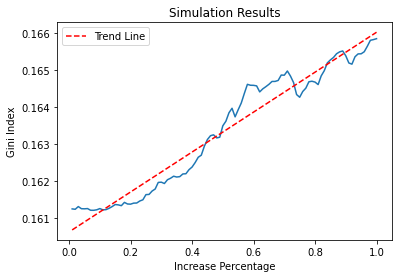

In [122]:
# Plot the results
fig, ax = plt.subplots()
ax.plot(increase_percentages, gini_indices_2)
ax.set_xlabel('Increase Percentage')
ax.set_ylabel('Gini Index')
ax.set_title('Simulation Results')
# Fit a polynomial of degree 1 (linear trend line) to the data
z = np.polyfit(increase_percentages, gini_indices_2, 1)
trend_line = np.poly1d(z)
# Plot the trend line
ax.plot(increase_percentages, trend_line(increase_percentages), 'r--', label='Trend Line')
ax.legend()
# Show the plot
plt.show()